<a href="https://colab.research.google.com/github/Manan-Parakh/CBTCIP-/blob/main/Iris_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# General Libraries
import pandas as pd
import numpy as np
import os
import sys
import sklearn

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)

# To Store the pretty images we create
ROOT = "."
PROJECT_NAME = "IRIS_FLOWER_CLASSIFICATION"
IMAGES_PATH = os.path.join(ROOT, PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(figname, extension = "png", resolution = 300, tight_layout = True):
  path = os.path.join(IMAGES_PATH, figname + '.' + extension)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format = extension, dpi = 300)

# Dataset

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [9]:
X = iris.data
y = iris.target.astype(int)

In [6]:
target_names = iris.target_names
feature_names = iris.feature_names
target_names, feature_names

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [7]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# Exploratory Data Analysis

In [ ]:
# Statistical Information
X.columns = feature_names
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
# Exploring the DataTypes and null values
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


# Data Visualization

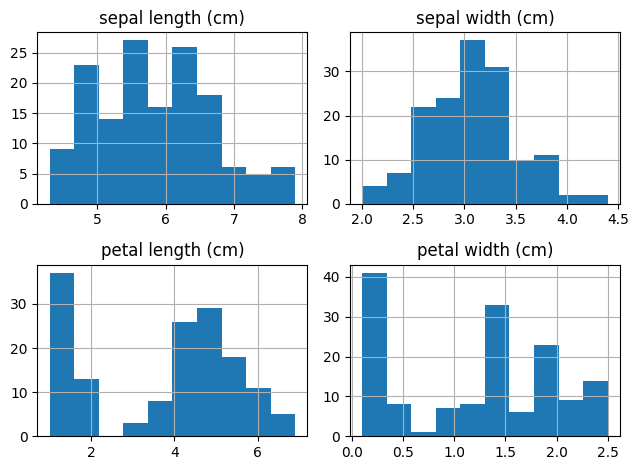

In [ ]:
X.hist()
save_fig('Distribution of Features')

In [ ]:
columns = ["sl", "sw", "pl", "pw", "target"]

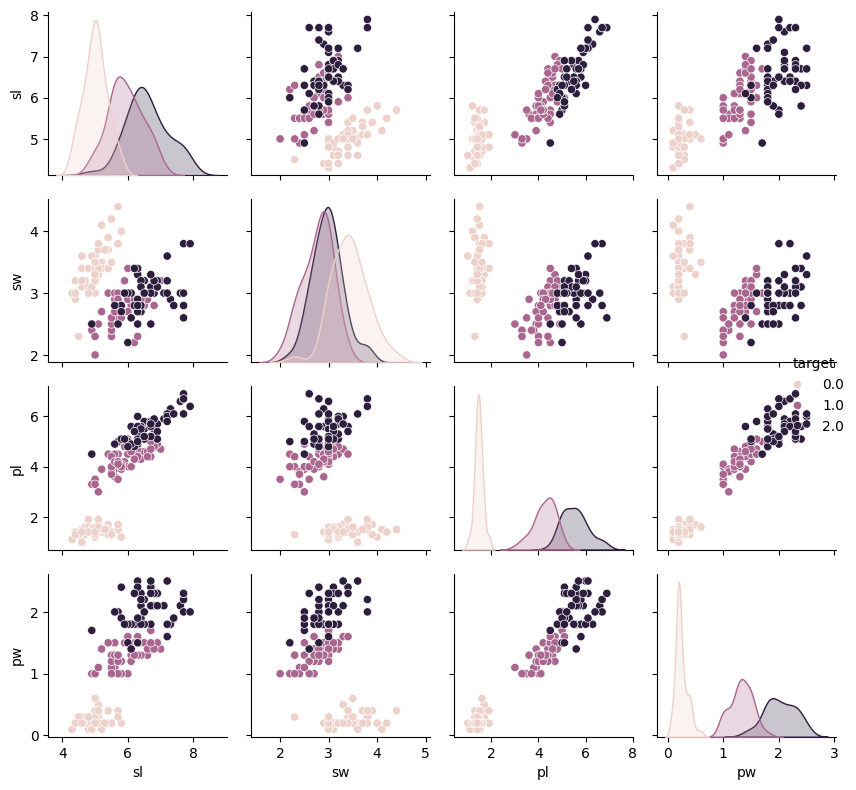

In [ ]:
sns.pairplot(pd.DataFrame(np.c_[X,y], columns = columns), hue = 'target', height = 2)
save_fig('PairPlot of Features')

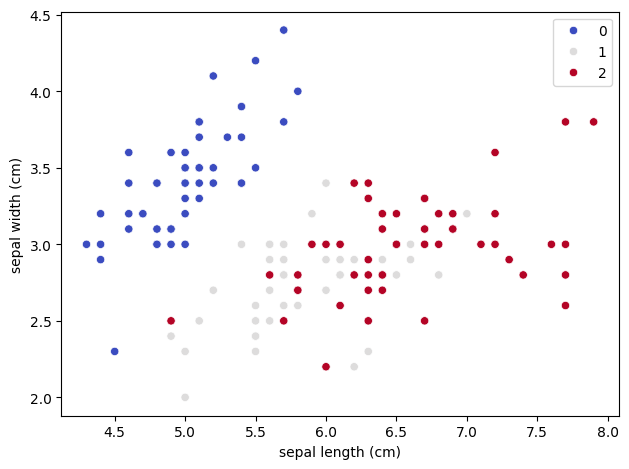

In [ ]:
# Let's view a particular chart
sns.scatterplot(x = X['sepal length (cm)'], y = X['sepal width (cm)'], hue = iris.target, palette = "coolwarm")
save_fig('sepal_width vs sepal_length')

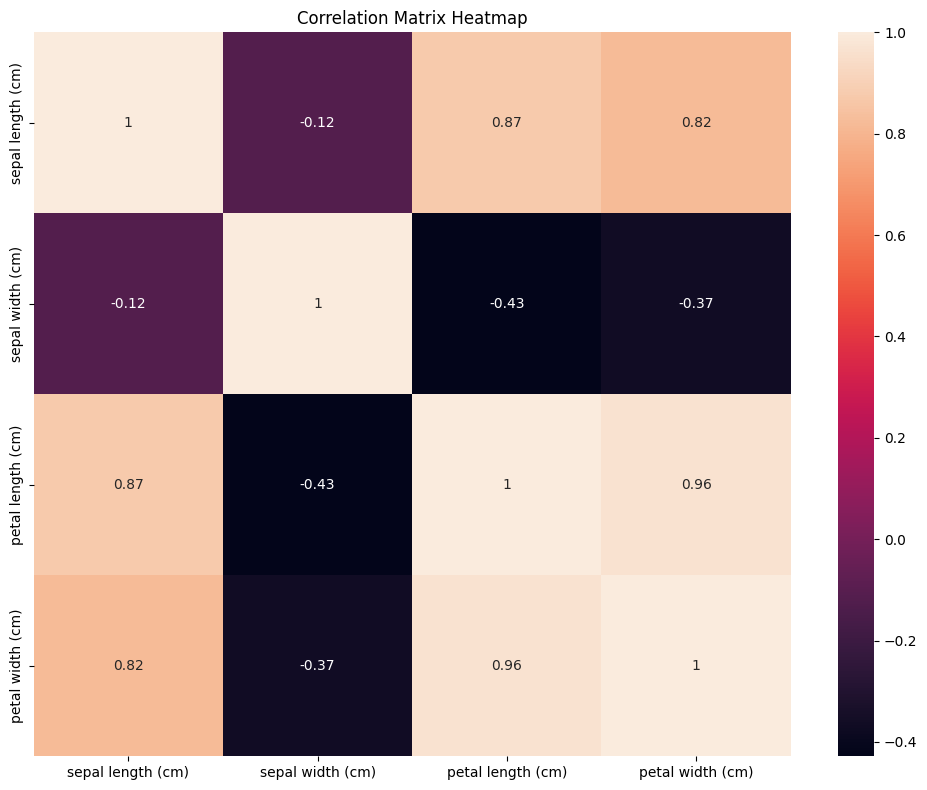

In [ ]:
# Correlation Matrix
corr_mat = X.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr_mat, annot = True)
plt.title("Correlation Matrix Heatmap")
save_fig('Features Correlation Matrix Heatmap')

# Principal Component Analysis

In [ ]:
# PCA -> To reduce dimensions
# For tree models, we generally do not need to scale the data. On the other hand, SVM is sensitive to the scale of the data.
# So we will scale the data when required.
# Model -> RFC, ExtraTrees, Boosted -> AdaBoost and GradientBoosting -> Find the best params for all of them and then compare their performances

In [11]:
# Try to reduce dimensions of the dataset
from sklearn.decomposition import PCA
pca = PCA()
# Finding the best number of components to reduce the data to
for comp in range(1,5):
  pca.n_components = comp
  X2 = pca.fit_transform(X)
  print(comp, pca.explained_variance_ratio_, round(sum(pca.explained_variance_ratio_),2))

1 [0.92461872] 0.92
2 [0.92461872 0.05306648] 0.98
3 [0.92461872 0.05306648 0.01710261] 0.99
4 [0.92461872 0.05306648 0.01710261 0.00521218] 1.0


In [12]:
# Choosing n_components to be 2, preserving 98 percent variance but reducing the feature space to just two dimensions.
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

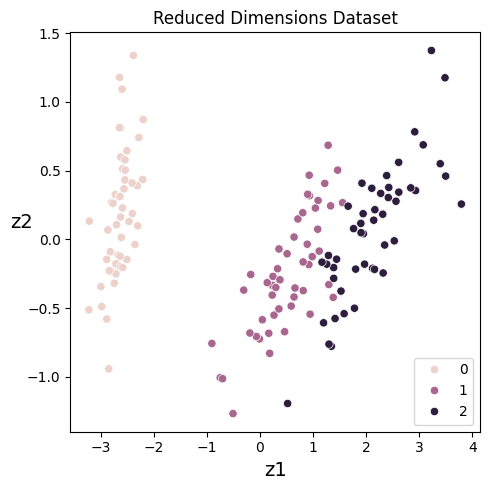

In [13]:
plt.figure(figsize = (5,5))
sns.scatterplot(x = X_reduced[:,0], y =X_reduced[:,1], hue = iris.target)
plt.xlabel("z1", fontsize = 14)
plt.ylabel("z2", fontsize = 14, rotation = 0)
plt.title('Reduced Dimensions Dataset')
save_fig("Reduced_Dimensions_Dataset")

In [14]:
# Split the dataset
# To ensure proper representation of all classes in the test and train set, we use StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits= 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(X_reduced,y):
  X_train = X_reduced[train_index]
  X_test = X_reduced[test_index]
  y_train = y[train_index].flatten()
  y_test = y[test_index].flatten()

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 2), (120,), (30, 2), (30,))

In [16]:
pd.Series(y_train.ravel()).value_counts()/len(y_train)

0    0.333333
2    0.333333
1    0.333333
Name: count, dtype: float64

In [17]:
pd.Series(y_test.ravel()).value_counts()/len(y_test)

0    0.333333
2    0.333333
1    0.333333
Name: count, dtype: float64

In [146]:
# After a lot of runs, it is getting hectic to calculate various metrics again and again,
# Lets create a function
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

def model_perf(model, figsave = True):
  """ Take the model,
  1. Fit the training data,
  2. Get the metrics on trained data and test data
  3. Metrics to get -> Accuracy, Precision, Recall and F1_score, Plot the Confusion Matrix, AUC and ROC curve
  """
  X_tr = X_train.copy()
  X_te = X_test.copy()
  y_tr = y_train.copy()
  y_te = y_test.copy()
  model.fit(X_tr, y_tr)
  y_pred_tr = model.predict(X_tr)
  y_pred_te = model.predict(X_te)

  # Accuracy
  accuracy_tr = cross_val_score(model, X_tr, y_tr, cv=5)
  print("Accuracy Score on Training Set:", accuracy_tr, "mean:", accuracy_tr.mean())

  # Classification_report
  cr_tr = pd.DataFrame(classification_report(y_tr, y_pred_tr, output_dict = True)).T
  cr_te = pd.DataFrame(classification_report(y_te, y_pred_te, output_dict = True)).T

  print('Train Report')
  print(cr_tr)

  print('Test Report')
  print(cr_te)

  # Plot the Heatmaps of Confusion matrix
  conf_mat_tr = confusion_matrix(y_tr, y_pred_tr)
  conf_mat_te = confusion_matrix(y_te, y_pred_te)
  fig, axes = plt.subplots(1,2, figsize = (10,5))
  sns.heatmap(conf_mat_tr, ax = axes[0], annot = True)
  sns.heatmap(conf_mat_te, ax = axes[1], annot = True)
  axes[0].set_title('Train Set')
  axes[1].set_title('Test Set')
  axes[0].set_xlabel('Predicted Class')
  axes[0].set_ylabel('Actual Class')
  axes[1].set_xlabel('Predicted Class')
  if figsave:
    save_fig(str(model) + " Report")

# Random Forest Classifier

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
import pickle
with open("/content/drive/MyDrive/CipherByte/IRIS/rnd_clf_pca.pkl", mode = 'rb') as file:
  rnd_clf = pickle.load(file)

In [ ]:
# Training a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier()

In [ ]:
# We will use GridSearchCV to figure out the best possible parameters for our RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameter_grid = {"n_estimators": np.arange(5,30,5),
                  "criterion": ['gini', 'entropy'],
                  "max_depth": range(1,4),
                  "min_samples_split": range(2,10)}
grid = GridSearchCV(rnd_clf, parameter_grid, cv = 3)
grid.fit(X_train, y_train)
grid.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too fe

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 15}

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 15}

In [ ]:
rnd_clf = grid.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Accuracy Score on Training Set: [0.875      0.95833333 0.95833333 0.91666667 0.91666667] mean: 0.925
Train Report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   40.000000
1              0.972973  0.900000  0.935065   40.000000
2              0.906977  0.975000  0.939759   40.000000
accuracy       0.958333  0.958333  0.958333    0.958333
macro avg      0.959983  0.958333  0.958275  120.000000
weighted avg   0.959983  0.958333  0.958275  120.000000
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  10.000000
1              0.900000  0.900000  0.900000  10.000000
2              0.900000  0.900000  0.900000  10.000000
accuracy       0.933333  0.933333  0.933333   0.933333
macro avg      0.933333  0.933333  0.933333  30.000000
weighted avg   0.933333  0.933333  0.933333  30.000000


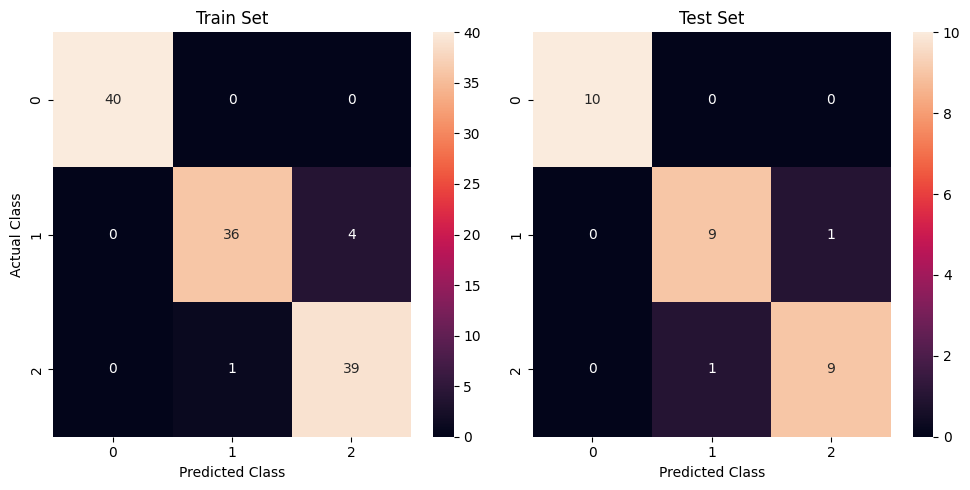

In [147]:
model_perf(rnd_clf)

In [ ]:
# Let's save the model so that we don't have to train it again and again
import pickle
with open("/content/drive/MyDrive/CipherByte/IRIS/rnd_clf_pca.pkl", mode = 'wb') as file:
  pickle.dump(rnd_clf, file)

## Using ExtraTreesClassifier

In [151]:
# importing the saved model from first run
with open("/content/drive/MyDrive/CipherByte/IRIS/extra_clf_pca.pkl", mode = 'rb') as file:
  extra_clf = pickle.load(file)

In [149]:
from sklearn.ensemble import ExtraTreesClassifier
extra_clf = ExtraTreesClassifier()

Accuracy Score on Training Set: [0.91666667 1.         0.95833333 0.95833333 0.95833333] mean: 0.9583333333333334
Train Report
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     40.0
1                   1.0     1.0       1.0     40.0
2                   1.0     1.0       1.0     40.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    120.0
weighted avg        1.0     1.0       1.0    120.0
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  10.000000
1              0.900000  0.900000  0.900000  10.000000
2              0.900000  0.900000  0.900000  10.000000
accuracy       0.933333  0.933333  0.933333   0.933333
macro avg      0.933333  0.933333  0.933333  30.000000
weighted avg   0.933333  0.933333  0.933333  30.000000


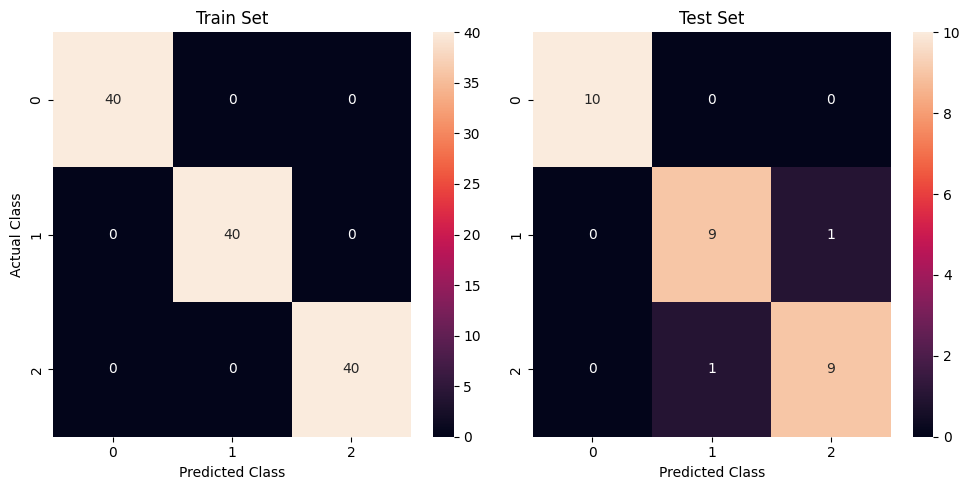

In [150]:
model_perf(extra_clf)
#Overfits

In [ ]:
params_grid_extra = {'n_estimators': range(1,15),
                     "max_depth": range(1,5),
                     "min_samples_split": range(2,9)}
grid_extra = GridSearchCV(ExtraTreesClassifier(), params_grid_extra, cv = 3)
grid_extra.fit(X_train, y_train)
grid_extra.best_params_

{'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 6}

In [ ]:
extra_clf = grid_extra.best_estimator_

In [155]:
extra_clf

ExtraTreesClassifier(max_depth=4, min_samples_split=4, n_estimators=6)

Accuracy Score on Training Set: [0.875      0.95833333 0.95833333 0.91666667 0.91666667] mean: 0.925
Train Report
              precision  recall  f1-score  support
0              1.000000    1.00  1.000000    40.00
1              0.947368    0.90  0.923077    40.00
2              0.904762    0.95  0.926829    40.00
accuracy       0.950000    0.95  0.950000     0.95
macro avg      0.950710    0.95  0.949969   120.00
weighted avg   0.950710    0.95  0.949969   120.00
Test Report
              precision  recall  f1-score  support
0              1.000000     1.0  1.000000     10.0
1              0.750000     0.6  0.666667     10.0
2              0.666667     0.8  0.727273     10.0
accuracy       0.800000     0.8  0.800000      0.8
macro avg      0.805556     0.8  0.797980     30.0
weighted avg   0.805556     0.8  0.797980     30.0


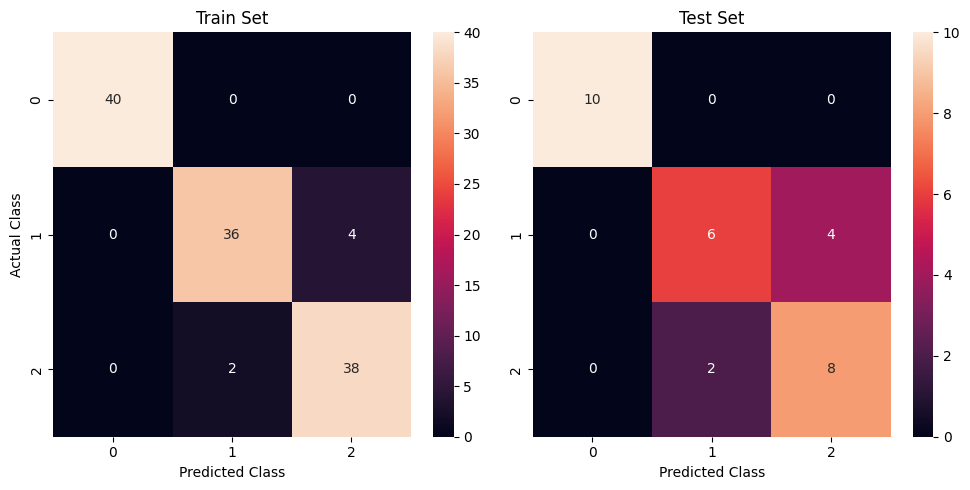

In [154]:
model_perf(extra_clf)

In [ ]:
with open("/content/drive/MyDrive/CipherByte/IRIS/extra_clf_pca.pkl", mode = 'wb') as file:
  pickle.dump(extra_clf, file)

# Using AdaBoost

In [53]:
# Importing the model from first run
with open("/content/drive/MyDrive/CipherByte/IRIS/ada_clf_pca.pkl", mode = 'rb') as file:
  ada_clf = pickle.load(file)

Accuracy Score on Training Set: [0.79166667 0.66666667 0.66666667 0.70833333 0.91666667] mean: 0.75
Accuracy Score on Testing Set: [0.83333333 0.66666667 0.83333333 1.         0.83333333] mean: 0.8333333333333334
Train Report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000   40.000000
1              0.540541  1.000000  0.701754   40.000000
2              1.000000  0.150000  0.260870   40.000000
accuracy       0.716667  0.716667  0.716667    0.716667
macro avg      0.846847  0.716667  0.654208  120.000000
weighted avg   0.846847  0.716667  0.654208  120.000000
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  10.000000
1              0.500000  1.000000  0.666667  10.000000
2              0.000000  0.000000  0.000000  10.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.500000  0.666667  0.555556  30.000000
weighted avg   0.500000  0.666667  0.555

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


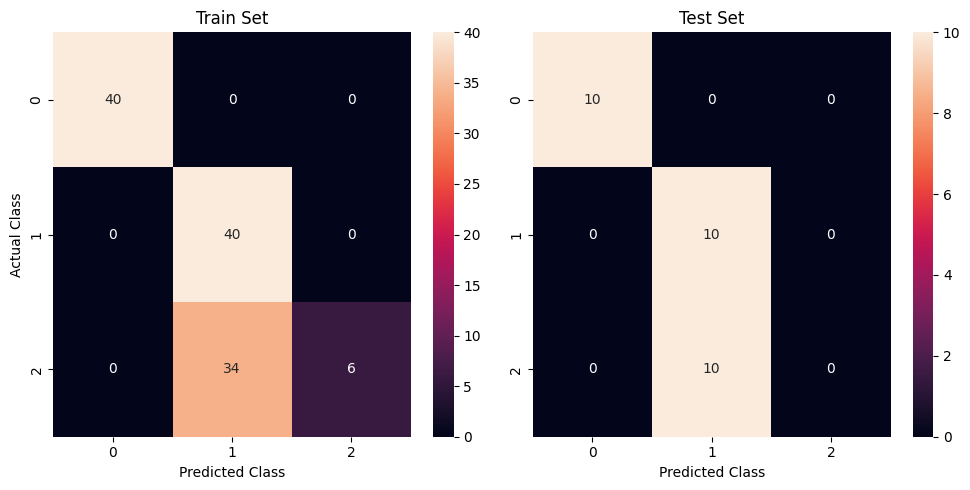

In [119]:
# Let's first evaluate the performance of Default Model
from sklearn.ensemble import AdaBoostClassifier
model_perf(AdaBoostClassifier())

The Default AdaBoostClassifier fails to capture the underlying pattern of the training dataset. Underfitting the data.
We will try to make the model more complex by:
1. Increasing the number of estimators.
2. Increasing the learning rate.
3. Will change the estimator to a more complex one than a Decision Stump, if required.

In [137]:
params_grid = {"learning_rate": np.arange(1.5,1.8,0.02),
               "n_estimators": range(70,85)
               }
grid_ada = GridSearchCV(AdaBoostClassifier(), params_grid, cv = 3, scoring = 'f1')
grid_ada.fit(X_train, y_train)
grid_ada.best_params_

Streaming output truncated to the last 5000 lines.
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1573, in precision_recall_fscore_support
    labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1391, in _check_set_wise_labels
    raise ValueError(
ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-pack

{'learning_rate': 1.5, 'n_estimators': 70}

In [138]:
grid_ada.best_params_

{'learning_rate': 1.5, 'n_estimators': 70}

In [144]:
ada_clf = grid_ada.best_estimator_
ada_clf.n_estimators = 65
ada_clf.learning_rate = 1.4

Accuracy Score on Training Set: [0.75       0.75       0.95833333 0.79166667 0.91666667] mean: 0.8333333333333334
Accuracy Score on Testing Set: [0.83333333 0.66666667 0.83333333 1.         0.83333333] mean: 0.8333333333333334
Train Report
              precision  recall  f1-score  support
0              1.000000    1.00  1.000000    40.00
1              1.000000    0.85  0.918919    40.00
2              0.869565    1.00  0.930233    40.00
accuracy       0.950000    0.95  0.950000     0.95
macro avg      0.956522    0.95  0.949717   120.00
weighted avg   0.956522    0.95  0.949717   120.00
Test Report
              precision    recall  f1-score    support
0              1.000000  1.000000  1.000000  10.000000
1              1.000000  0.900000  0.947368  10.000000
2              0.909091  1.000000  0.952381  10.000000
accuracy       0.966667  0.966667  0.966667   0.966667
macro avg      0.969697  0.966667  0.966583  30.000000
weighted avg   0.969697  0.966667  0.966583  30.000000


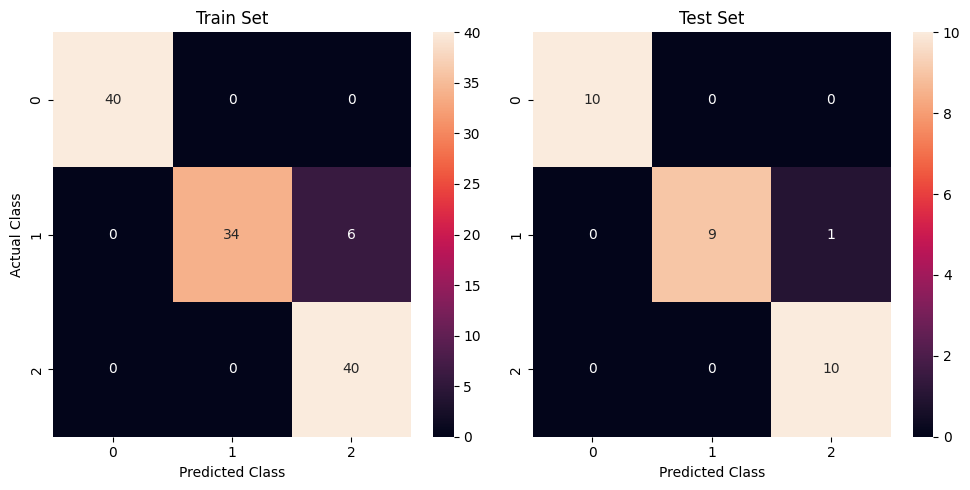

In [145]:
model_perf(ada_clf)

In [114]:
with open("/content/drive/MyDrive/CipherByte/IRIS/ada_clf_pca.pkl", mode = 'wb') as file:
  pickle.dump(ada_clf, file)

# Using Gradient Boosting

In [ ]:
# Importing the model from previous run
with open("/content/drive/MyDrive/CipherByte/IRIS/gbc_clf.pkl", mode = 'rb') as file:
  gbc_clf = pickle.load(file)

Accuracy Score on Training Set: 1.0
Accuracy Score on Testing Set: 0.9333333333333333
Train Report
              precision  recall  f1-score  support
0.0                 1.0     1.0       1.0     40.0
1.0                 1.0     1.0       1.0     40.0
2.0                 1.0     1.0       1.0     40.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    120.0
weighted avg        1.0     1.0       1.0    120.0
Test Report
              precision  recall  f1-score  support
0.0                 1.0     1.0       1.0     40.0
1.0                 1.0     1.0       1.0     40.0
2.0                 1.0     1.0       1.0     40.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    120.0
weighted avg        1.0     1.0       1.0    120.0


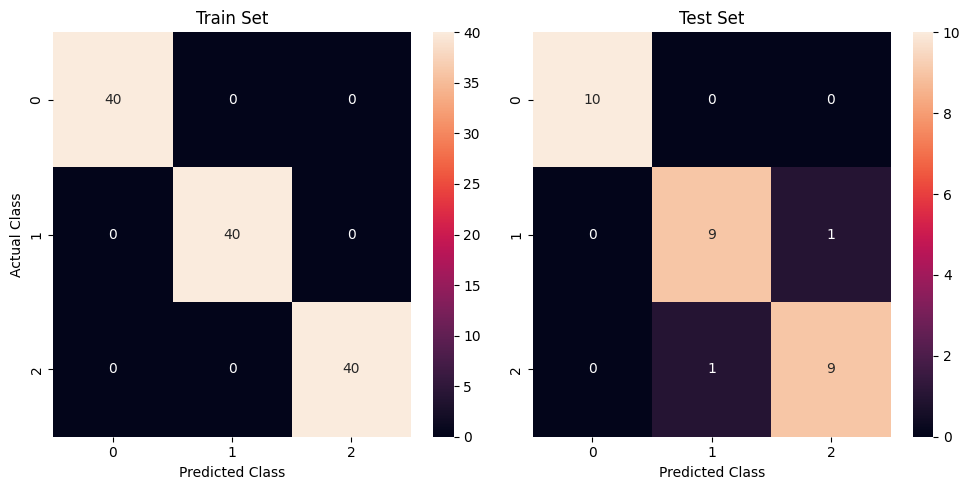

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_clf = GradientBoostingClassifier()
model_perf(gbc_clf)

In [ ]:
params_grid_gbc = {"n_estimators": range(1,10),
                   "learning_rate": np.arange(0.01,0.5,0.05),
                   "max_depth": range(1,4),
                   "min_samples_split": range(2,10)}
grid_gbc = GridSearchCV(gbc_clf, params_grid_gbc, cv = 3)
grid_gbc.fit(X_train,y_train)
grid_gbc.best_params_

{'learning_rate': 0.36000000000000004,
 'max_depth': 3,
 'min_samples_split': 6,
 'n_estimators': 9}

Accuracy Score on Training Set: 0.95
Accuracy Score on Testing Set: 0.9
Train Report
              precision  recall  f1-score  support
0.0               1.000   1.000     1.000    40.00
1.0               0.925   0.925     0.925    40.00
2.0               0.925   0.925     0.925    40.00
accuracy          0.950   0.950     0.950     0.95
macro avg         0.950   0.950     0.950   120.00
weighted avg      0.950   0.950     0.950   120.00
Test Report
              precision  recall  f1-score  support
0.0               1.000   1.000     1.000    40.00
1.0               0.925   0.925     0.925    40.00
2.0               0.925   0.925     0.925    40.00
accuracy          0.950   0.950     0.950     0.95
macro avg         0.950   0.950     0.950   120.00
weighted avg      0.950   0.950     0.950   120.00


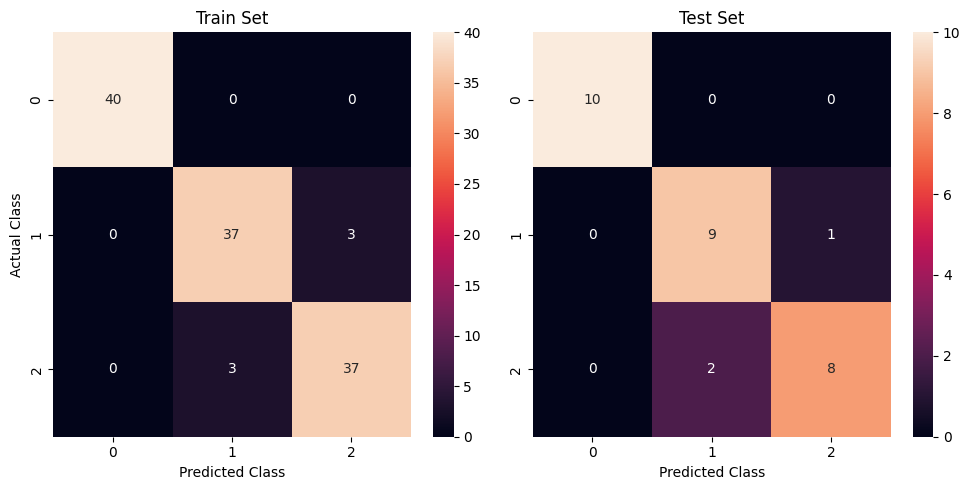

In [ ]:
# The model given by GridSearch was overfitting, by hit and trial we reach the folowing model.
gbc_clf = GradientBoostingClassifier(n_estimators = 3, min_samples_split = 8, learning_rate = 0.25, max_depth = 2)
model_perf(gbc_clf)

In [ ]:
cross_val_score(gbc_clf, X_train, y_train, cv = 3)
# The model is not overfitting too much

array([0.9  , 0.925, 0.95 ])

In [ ]:
with open("/content/drive/MyDrive/CipherByte/IRIS/gbc_clf_pca.pkl", mode ="wb") as file:
  pickle.dump(gbc_clf, file)

# Using XGBoost

In [ ]:
# load the model from previous run
with open("/content/drive/MyDrive/CipherByte/IRIS/xgb_clf.pkl", mode = 'rb') as file:
  xgb_clf = pickle.load(file)

Accuracy Score on Training Set: 1.0
Accuracy Score on Testing Set: 0.9
Train Report
              precision  recall  f1-score  support
0.0                 1.0     1.0       1.0     40.0
1.0                 1.0     1.0       1.0     40.0
2.0                 1.0     1.0       1.0     40.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    120.0
weighted avg        1.0     1.0       1.0    120.0
Test Report
              precision  recall  f1-score  support
0.0                 1.0     1.0       1.0     40.0
1.0                 1.0     1.0       1.0     40.0
2.0                 1.0     1.0       1.0     40.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    120.0
weighted avg        1.0     1.0       1.0    120.0


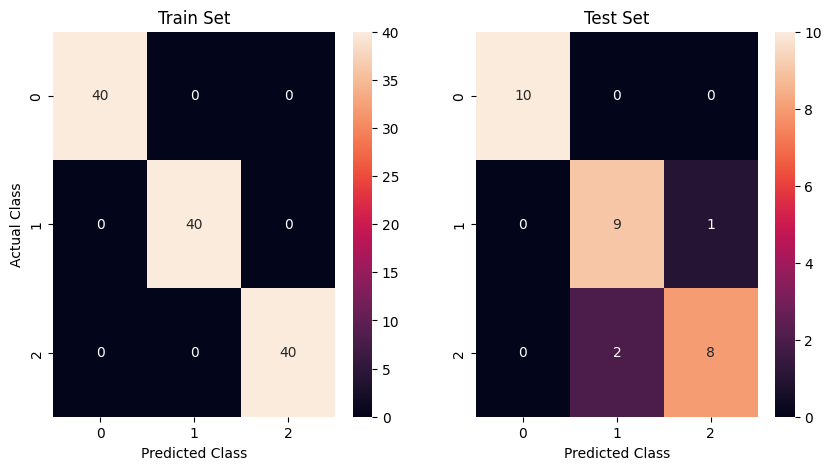

In [ ]:
import xgboost
xgb_clf = xgboost.XGBClassifier()
model_perf(xgb_clf, figsave = False)
# It Overfits, let's tune the hyperparamters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params_grid_xgb = {
    'eta': [0.1, 0.3],
    'max_depth': range(1,5),
    'min_child_weight': range(1,4),
    'gamma': np.random.rand(100),
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
    }
grid_random_xgb = RandomizedSearchCV(xgb_clf, params_grid_xgb, n_iter = 100)
grid_random_xgb.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False, eta=1,
                                           eval_metric=None, feature_types=None,
                                           gamma=0, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=N...
       0.75499853, 0.78746071, 0.69089005, 0.77421318, 0.8741171 ,
       0.5300239 , 0.46960116, 0.01851199, 0.11561584, 0.28098164,
       0.97536809, 0.91719777, 0.03025001, 0.77644766, 0.90608165,
       0.45342243, 0.10206817, 0.10175718, 0.09909158, 0.11666666,
       0.94352967, 0.1290607 , 0.05578172, 0.20257871, 0.84976092,
       0.40028931, 0.39406774, 0.25126664, 0.1965203 , 0.93923383]),
                                        'max_depth': range(1, 5),
                                        'min_child_weight': range(1, 4),
                                        'subsample': [0.8, 1]})

In [ ]:
grid_random_xgb.best_params_

{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 1,
 'gamma': 0.19652030413716248,
 'eta': 0.1,
 'colsample_bytree': 0.8}

Accuracy Score on Training Set: 0.9666666666666667
Accuracy Score on Testing Set: 0.9
Train Report
              precision    recall  f1-score     support
0.0            1.000000  1.000000  1.000000   40.000000
1.0            0.928571  0.975000  0.951220   40.000000
2.0            0.973684  0.925000  0.948718   40.000000
accuracy       0.966667  0.966667  0.966667    0.966667
macro avg      0.967419  0.966667  0.966646  120.000000
weighted avg   0.967419  0.966667  0.966646  120.000000
Test Report
              precision    recall  f1-score     support
0.0            1.000000  1.000000  1.000000   40.000000
1.0            0.928571  0.975000  0.951220   40.000000
2.0            0.973684  0.925000  0.948718   40.000000
accuracy       0.966667  0.966667  0.966667    0.966667
macro avg      0.967419  0.966667  0.966646  120.000000
weighted avg   0.967419  0.966667  0.966646  120.000000


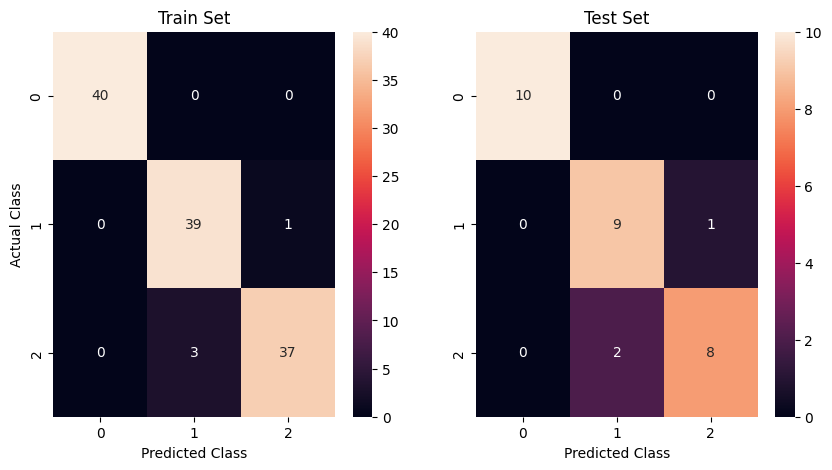

In [ ]:
xgb_clf = grid_random_xgb.best_estimator_
model_perf(xgb_clf, figsave = False)

In [ ]:
cross_val_score(xgb_clf, X_train, y_train, cv = 3)
# Not overfitting too much!

array([0.925, 1.   , 0.9  ])

In [ ]:
# Save the model for future use
with open("/content/drive/MyDrive/CipherByte/IRIS/xgb_clf_pca.pkl", mode = 'wb') as file:
  pickle.dump(xgb_clf, file)